## 项目背景介绍
> 
+ 在本项目中，基于MindSpore框架使用 MedMNIST 提供的 PathMNIST 数据集，利用预训练的 Vision Transformer（ViT）模型对结直肠组织图像进行多分类任务；
+ PathMNIST 为 MedMNIST v2 中的一个子集，专注于结直肠癌组织切片的多分类任务，共包含约 100,000 张 28×28 彩色图像，涵盖 9 类组织类型，包括正常粘膜、癌相关间质、淋巴细胞等。  PathMNIST 数据集经过统一尺寸与预处理，便于快速原型开发与模型评估；  
+ 结直肠癌是全球发病率和死亡率较高的恶性肿瘤之一，早期病理筛查与分类对提高诊断准确性和治疗效果至关重要。利用自动化图像识别技术，可减轻病理专家工作量并提升诊断一致性。      

## 模型简介
>
+ ViT 通过将图像划分为固定大小的“patch”并在 Transformer 编码器上进行自注意力计算，展现出在各类视觉任务上媲美或超越传统 CNN 的性能；
+ 采用 MindVision 提供的 vit_b_16 模型，该模型在 ImageNet-21k 上预训练，并在 ImageNet-1k 上微调后提供良好泛化性能；
+ 将原有的 1000 类分类头替换为适应 PathMNIST 的 9 类输出层，保留主干 Transformer 权重，以加速下游任务训练。

## 环境配置

In [ ]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.5.0，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [5]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


In [3]:
!pip install medmnist
!export HF_ENDPOINT=https://hf-mirror.com

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 69.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 22.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.9 MB/s eta 0:00:00
  DEPRECATION: Building 'fire' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'fire'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114298 sha256=f3193544b185fc1ee

## 数据集加载及预处理

In [1]:
import os
import mindspore
from mindspore import dataset as ds
from medmnist import INFO, PathMNIST
import mindspore.dataset.vision as vision
from mindspore.dataset import GeneratorDataset
from mindspore.dataset import transforms as c_transforms


# 指定数据集
data_flag = 'pathmnist'
download_root = './data'
os.makedirs(download_root, exist_ok=True) 
# 从 INFO 中读取所有可用字段
info = INFO[data_flag]

# 直接根据标签列表计算类别数
labels = info['label']           # 每个元素是一个类别名称
num_classes = len(labels)        # 类别总数 :contentReference[oaicite:0]{index=0}
n_channels  = info['n_channels'] # 通道数

# 下载并加载数据
train_dataset = PathMNIST(root=download_root, split='train', download=True)
val_dataset   = PathMNIST(root=download_root, split='val',   download=True)

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
def create_dataset(dataset, batch_size=32, shuffle=True):
    py_ops = [
        vision.Resize((224, 224)),   # 对 PIL/ndarray 做缩放
        vision.ToTensor(),           # 转为 [C,H,W] float32, 0~1
    ]
    ds = GeneratorDataset(dataset, column_names=['image','label'], shuffle=shuffle)  # image 已是 PIL/ndarray :contentReference[oaicite:5]{index=5}
    ds = ds.map(input_columns=['image'], operations=py_ops)                            # 直接用 Python transforms :contentReference[oaicite:6]{index=6}
    ds = ds.map(input_columns=['label'], operations=lambda x: x.squeeze().astype('int32'))
    ds = ds.batch(batch_size)
    return ds


# 构造训练/验证集
train_ds = create_dataset(train_dataset, batch_size=64, shuffle=True)
val_ds   = create_dataset(val_dataset,   batch_size=64, shuffle=False)

从数据集随机选取9个样本展示

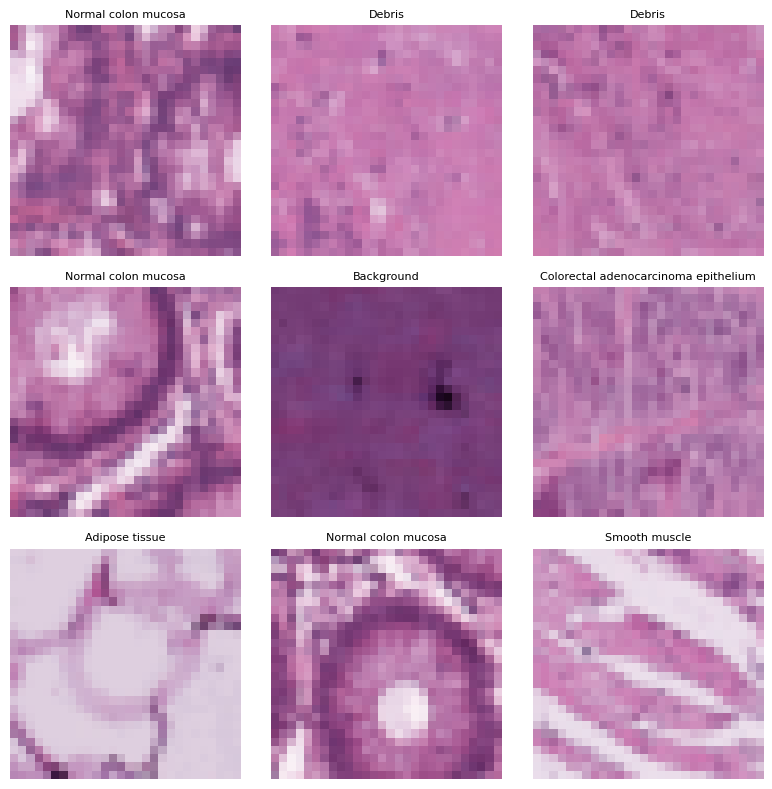

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from medmnist import PathMNIST

# 定义类别名称
labels = [
    'Adipose tissue',
    'Background',
    'Debris',
    'Lymphocytes',
    'Mucus',
    'Smooth muscle',
    'Normal colon mucosa',
    'Cancer-associated stroma',
    'Colorectal adenocarcinoma epithelium'
]

# 假设 train_dataset 已经初始化好
num_samples = 9
indices = np.random.choice(len(train_dataset), num_samples, replace=False)

plt.figure(figsize=(8, 8))
for i, idx in enumerate(indices):
    pil_img, target = train_dataset[idx]
    cls = int(target.item())         # 获取整数标签
    class_name = labels[cls]         # 查找类别名称

    # 将 PIL Image 转为 NumPy 数组
    img_np = np.array(pil_img)

    plt.subplot(3, 3, i + 1)
    # 根据数组维度决定用灰度还是彩色显示
    if img_np.ndim == 2:
        plt.imshow(img_np, cmap='gray')
    else:
        plt.imshow(img_np)
    plt.title(class_name, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 模型构建

In [4]:
import mindspore as ms
from mindspore import nn, context
from mindspore.train.callback import LossMonitor, ModelCheckpoint, CheckpointConfig
from mindvision.classification.models import vit_b_16
from mindspore.train import Model
from mindspore.train.metrics import Accuracy


# 加载预训练 ViT 并替换分类头
net = vit_b_16(pretrained=True, num_classes=1000, image_size=224)
net.head = nn.Dense(in_channels=768, out_channels=num_classes)  # 9 类

# 定义损失函数与优化器
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
optimizer = nn.Adam(net.trainable_params(), learning_rate=2e-4)

# 初始化 Accuracy 指标
accuracy_metric = Accuracy()

# 定义 Model，确保 metrics 为字典格式
model = Model(net, loss_fn=loss_fn, optimizer=optimizer, metrics={"Accuracy": accuracy_metric})

[WARNING] ME(6494:281473106489376,MainProcess):2025-05-13-01:24:23.824.917 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(6494:281473106489376,MainProcess):2025-05-13-01:24:23.869.322 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(6494:281473106489376,MainProcess):2025-05-13-01:24:23.882.181 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(6494:281473106489376,MainProcess):2025-05-13-01:24:23.961.628 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(6494:281473106489376,MainProcess):2025-05-13-01:24:23.999.259 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(6494:281473106489376,M

## 模型训练

In [5]:
# 每 100 步保存一次，最多保留 3 个检查点
ckpt_config = CheckpointConfig(save_checkpoint_steps=100, keep_checkpoint_max=3)
ckpt_cb = ModelCheckpoint(prefix="vit_pathmnist",
                          directory="./checkpoints",
                          config=ckpt_config)

# 开始训练
epoch_num = 3
print(f"Start training for {epoch_num} epochs, dataset size: {train_ds.get_dataset_size()} batches")
model.train(epoch_num,
            train_dataset=train_ds,
            callbacks=[LossMonitor(per_print_times=50), ckpt_cb],
            dataset_sink_mode=False)

Start training for 3 epochs, dataset size: 1407 batches


[WARNING] DEVICE(6494,ffff9086b020,python):2025-05-13-01:24:30.385.738 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_vmm_adapter.h:147] CheckVmmDriverVersion] Open file /etc/ascend_install.info failed.
[WARNING] DEVICE(6494,ffff9086b020,python):2025-05-13-01:24:30.385.859 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_vmm_adapter.h:186] CheckVmmDriverVersion] Driver version is less than 24.0.0, vmm is disabled by default, drvier_version: 23.0.6


.epoch: 1 step: 50, loss is 2.1977615356445312
epoch: 1 step: 100, loss is 2.2292211055755615
epoch: 1 step: 150, loss is 1.9665098190307617
epoch: 1 step: 200, loss is 1.686094045639038
epoch: 1 step: 250, loss is 1.714059591293335
epoch: 1 step: 300, loss is 1.810146689414978
epoch: 1 step: 350, loss is 1.755419373512268
epoch: 1 step: 400, loss is 1.5137240886688232
epoch: 1 step: 450, loss is 1.2674505710601807
epoch: 1 step: 500, loss is 1.2926620244979858
epoch: 1 step: 550, loss is 1.4577109813690186
epoch: 1 step: 600, loss is 1.3775129318237305
epoch: 1 step: 650, loss is 1.1601834297180176
epoch: 1 step: 700, loss is 0.9986368417739868
epoch: 1 step: 750, loss is 0.8986308574676514
epoch: 1 step: 800, loss is 0.9380717873573303
epoch: 1 step: 850, loss is 0.9710489511489868
epoch: 1 step: 900, loss is 1.041949987411499
epoch: 1 step: 950, loss is 0.8818055391311646
epoch: 1 step: 1000, loss is 0.8953267931938171
epoch: 1 step: 1050, loss is 0.9770921468734741
epoch: 1 step: 1

## 模型评估

In [6]:
print("Evaluating on validation set...")
metrics = model.eval(val_ds, dataset_sink_mode=False)
print("Validation metrics:", metrics)

Evaluating on validation set...
Validation metrics: {'Accuracy': 0.8251699320271891}
